<a href="https://colab.research.google.com/github/LaraN01/DrugData_AdverseEvents/blob/main/Notebook_4_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import the libraries

In [ ]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline


# 2. Load the data

In [ ]:
# To activate when running on colab:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/CAS_2023/final_dataset.csv'

In [ ]:
data=pd.read_csv(dataset_path,index_col=0, dtype={
    'UNII Codes for Inactive Ingredients':'O',
    'UNII Codes for Active Ingredients':'O',
    'Routes of Administration':'O',
    'Product Types':'O',
    'charge':'f4',
    'count':'f4',
    'stereochemistry':'O',
    'defined_stereo':'f4',
    'ez_centers':'f4',
    'molecular_weight':'f4',
    'optical_activity':'O',
    'stereo_centers':'f4',
    'patientsex':'O',
    'risk score':'f4'} )

# 3. Prepare the dataset

There is three product types: 'HUMAN PRESCRIPTION DRUG', 'HUMAN OTC DRUG', 'CELLULAR THERAPY'.
To select a different one change the target entry in the corresponing field of the loading function below.

Route of administration has as well fifferent options: 'PARENTERAL', 'TOPICAL', 'UROGENITAL', 'ORAL' and 'RESPIRATORY (INHALATION)'. To select the desired one for the training and ML just change the entry in the corresponding field below.

In [ ]:
def drugs_dataset(data):
    # Select the product type subcategory and route of aministration subcategory as applicable
    data_human=data[data['Product Types']=='HUMAN PRESCRIPTION DRUG']
    #data_human_parenteral=data_human[data_human['Routes of Administration']=='ORAL']

    # For now removed also patientsex, we may add it again to see if it plays a role
    # Defined_stereo is always identical to stereo_centers, therefore one of the two was removed
    result=data_human.drop(['Routes of Administration','Product Types','defined_stereo','patientsex'], axis=1)

    return result

In [ ]:
drugs=drugs_dataset(data)

# 4. General evaluation (shape, info, describe, distribution)

In [ ]:
drugs.head(5)

,UNII Codes for Inactive Ingredients,UNII Codes for Active Ingredients,charge,count,stereochemistry,ez_centers,molecular_weight,optical_activity,stereo_centers,risk score
14,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
15,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
16,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0
17,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,9.0
18,"8SKN0B0MIM, 55X04QC32I, 506T60A25R, W4888I119H...",L6UH7ZF8HC,0.0,1.0,ACHIRAL,0.0,410.485413,NONE,0.0,7.0


In [ ]:
#drugs.columns

In [ ]:

# # Group by 'UNII Codes for Active Ingredients' and calculate mean for 'risk score'
# drugs = drugs.groupby('UNII Codes for Active Ingredients', as_index=False).agg({
#     'risk score': 'mean',
#     'UNII Codes for Inactive Ingredients': 'first',  # Assuming other columns have the same values within groups
#     'charge': 'first',
#     'count': 'first',
#     'stereochemistry': 'first',
#     'ez_centers': 'first',
#     'molecular_weight': 'first',
#     'optical_activity': 'first',
#     'stereo_centers': 'first'})



In [ ]:
# Display the result
# drugs.head()

In [ ]:
drugs.shape

(8217234, 10)

In [ ]:
drugs.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8217234 entries, 14 to 9224478
Data columns (total 10 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   UNII Codes for Inactive Ingredients  8217234 non-null  object 
 1   UNII Codes for Active Ingredients    8217234 non-null  object 
 2   charge                               8217234 non-null  float32
 3   count                                8217234 non-null  float32
 4   stereochemistry                      8217234 non-null  object 
 5   ez_centers                           8217234 non-null  float32
 6   molecular_weight                     8217234 non-null  float32
 7   optical_activity                     8217234 non-null  object 
 8   stereo_centers                       8217234 non-null  float32
 9   risk score                           8217234 non-null  float32
dtypes: float32(6), object(4)
memory usage: 501.5+ MB


In [ ]:
drugs.describe()

,charge,count,ez_centers,molecular_weight,stereo_centers,risk score
count,8.217234e+06,8.217234e+06,8.217234e+06,8.217234e+06,8.217234e+06,8.217234e+06
mean,-5.319576e-02,1.079605e+00,1.209759e-01,3.798933e+02,2.173879e+00,8.509642e+00
std,5.342250e-01,2.978044e-01,5.138111e-01,2.038747e+02,3.271389e+00,2.702832e+00
min,-1.000000e+01,1.000000e+00,0.000000e+00,1.007900e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,2.774024e+02,0.000000e+00,7.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,3.584289e+02,1.000000e+00,9.000000e+00
75%,0.000000e+00,1.000000e+00,0.000000e+00,4.483861e+02,3.000000e+00,1.000000e+01
max,3.000000e+00,6.000000e+00,7.000000e+00,3.562182e+03,4.000000e+01,1.500000e+01


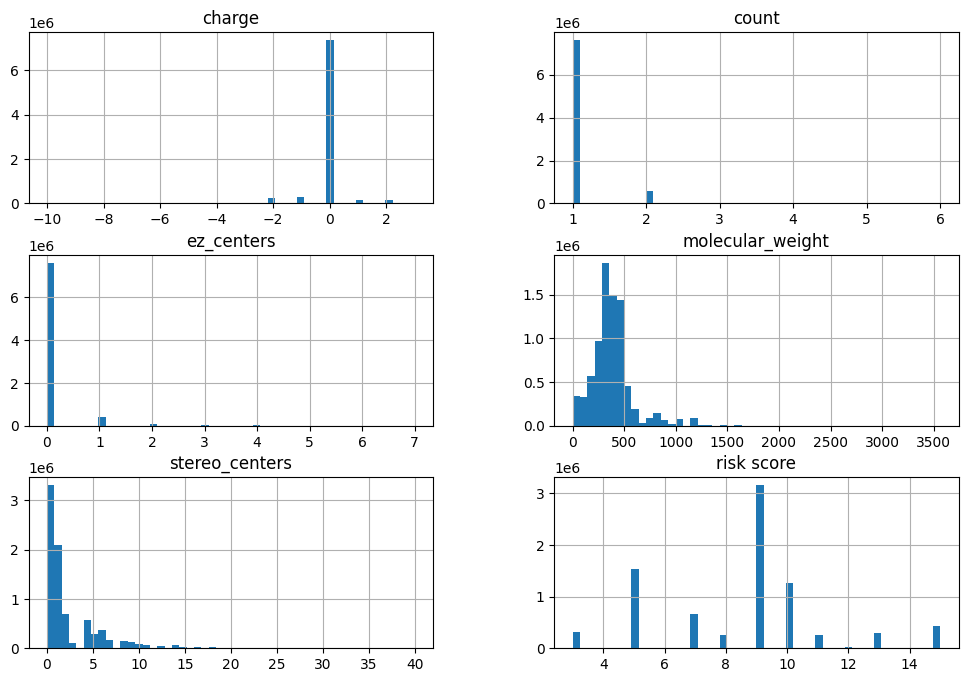

In [ ]:
drugs_num=drugs.select_dtypes(include=[np.number])
drugs_num.hist(bins=50, figsize=(12,8))
plt.show()

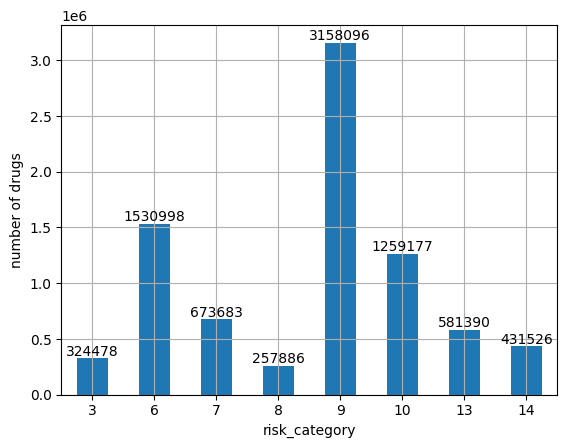

In [ ]:
drugs['risk_cat']=pd.cut(drugs['risk score'],
                         bins=[0,3,6,7,8,9,10,13,np.inf],
                         labels=[3,6,7,8,9,10,13,14])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

risk_counts=drugs['risk_cat'].value_counts().sort_index()
ax=risk_counts.plot(kind='bar', rot=0, grid=True)
for i, v in enumerate(risk_counts):
    ax.text(i,v +0.1, str(v), ha='center', va='bottom')
plt.xlabel('risk_category')
plt.ylabel('number of drugs')
plt.show()

In [ ]:
# drugs['risk_cat']=pd.cut(drugs['risk score'],
#                          bins=[0,5,8,11,np.inf],
#                          labels=[5,8,11,13])   # 3 is all <=3, 6 is 4-6, 13 is 11-13, 14 is >=14

# risk_counts=drugs['risk_cat'].value_counts().sort_index()
# ax=risk_counts.plot(kind='bar', rot=0, grid=True)
# for i, v in enumerate(risk_counts):
#     ax.text(i,v +0.1, str(v), ha='center', va='bottom')
# plt.xlabel('risk_category')
# plt.ylabel('number of drugs')
# plt.show()

NOTE: ensure that all categories have >=2 entries, if not adapt the bins  
This is required for the stratified splitter

# 5. Train set, test set, validation set

## 5.1 Train set, test set

In [ ]:
splitter=StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(drugs, drugs['risk_cat']):
    strat_train_set=drugs.iloc[train_index]
    strat_test_set=drugs.iloc[test_index]

features=['UNII Codes for Inactive Ingredients',
          'UNII Codes for Active Ingredients',
          'charge',
          'count',
          'stereochemistry',
          'ez_centers',
          'molecular_weight',
          'optical_activity',
          'stereo_centers',]

target_feature='risk score'

X_train=strat_train_set[features]
y_train=strat_train_set[target_feature]
X_test=strat_test_set[features]
y_test=strat_test_set[target_feature]

In [ ]:
print('X train shape = ', X_train.shape)
print('X test shape = ', X_test.shape)

X train shape =  (6573787, 9)
X test shape =  (1643447, 9)


# 6. Feature scaling and transformation

## 6.1 Custom transformers

In [ ]:
class CustomMultilabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        #print("Fitting CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        self.mlb.fit(X)
        self.known_classes_ = set(self.mlb.classes_)
        print("Known classes:", self.known_classes_)
        return self

    def transform(self, X):
        #print("Transforming with CustomMultilabelBinarizer...")
        X = self._apply_eval(X)
        #print("Evaluated input:", X)
        filtered_X = [
            [label for label in labels if label in self.known_classes_]
            for labels in X
        ]
        transformed_X = self.mlb.transform(filtered_X)
        #print("Transformed data:", transformed_X)
        return transformed_X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

    def _apply_eval(self, X):
        def safe_eval(x):
            try:
                result = x.split(', ') if isinstance(x, str) else x
                #print(f"Evaluating: {x} -> {result}")
                return result
            except Exception as e:
                #print(f"Error evaluating: {x} with error {e}")
                return []
        return [safe_eval(x) for x in X]


# NOTE: Un-comment the print checks only if needed for debugging/monitoring.
# With print statements require > 15GB RAM and cannot be saved (JSON string too long)

## 6.2 Pipelines and pre-processing

In [ ]:
cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

mlb_pipeline=make_pipeline(
    CustomMultilabelBinarizer())

num_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    StandardScaler())

log_pipeline=make_pipeline(
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

cbrt_pipeline=make_pipeline(
    FunctionTransformer(np.cbrt, feature_names_out='one-to-one'),
    StandardScaler())

In [ ]:
preprocessor=ColumnTransformer([
    ('1H_encoded', cat_pipeline,['stereochemistry','optical_activity']),
    ('numericals', num_pipeline,['charge', 'count','ez_centers']),
    ('log_feat', log_pipeline, ['molecular_weight']),
    ('cbrt_feat', cbrt_pipeline, ['stereo_centers']),
    ('mlb', CustomMultilabelBinarizer(), 'UNII Codes for Inactive Ingredients'),
    ('ord_enc',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), ['UNII Codes for Active Ingredients'])])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [ ]:
pipeline.fit(X_train)

Known classes: {'79Y1949PYO', '24H4NWX5CO', 'HS7EB0C1ZH', 'M911911U02', 'SA6A6V432S', 'FZ989GH94E', '33GX5WQC0M', '8A6OMU3I8L', '2RJS3559D3', 'ND2M416302', '5TL50QU0W4', 'ECW0LZ41X8', 'HE0P2D9ZLS', 'J3QD0LD11P', '5856J3G2A2', '13A4J4NH9I', '5SL0G7R0OK', 'P2OM2Q86BI', '6P92858988', '53J3F32P58', 'H5ZC52369M', 'SE337SVY37', 'IDK7C2HS09', 'EWQ57Q8I5X', '21C2F5E8RE', '225ZLC74HX', 'R8WTH25YS2', 'A2M91M918C', 'X33R8U0062', 'UF064M00AF', '39J80LT57T', '91XW058U2C', '9G34HU7RV0', 'H0G9379FGK', '0MKJ04EU89', '603RP8TB9A', '3OWL53L36A', '1Q73Q2JULR', 'OJ4Z5Z32L4', 'ZYD53NBL45', 'BPV390UAP0', 'XB09609XSL', '65UEH262IS', '461N1O614Y', '98553S1MHQ', '4ELV7Z65AP', '4AJZ4765R9', '6LV4FOR43R', 'W4X6ZO7939', 'G5SU0BFK7O', '076NU497LZ', '48268V50D5', '88XHZ13131', '230OU9XXE4', '3FTR44B32Q', '3X4P6271OX', '2PP9364507', 'T75W9911L6', 'RV6J6604TK', 'AZE05TDV2V', '46N107B71O', 'XHX3C3X673', 'H1109Z9J4N', 'X9N69O5R5X', '32K497ZK2U', '4N14V5R27W', '532B59J990', 'JR9CE63FPM', '5655G9Y8AQ', 'VR5Y7PDT5W', '4X4

In [ ]:
X_train_preprocessed = pipeline.transform(X_train)

In [ ]:
X_test_preprocessed = pipeline.transform(X_test)

In [ ]:
print('Train set shape= ', X_train_preprocessed.shape)
print('Test set shape= ', X_test_preprocessed.shape)

In [ ]:
df_X_train_preprocessed=pd.DataFrame(X_train_preprocessed,
                                     columns=preprocessor.get_feature_names_out(),
                                     index=X_train.index)

df_X_test_preprocessed=pd.DataFrame(X_test_preprocessed,
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_test.index)

In [ ]:
# df_X_train_preprocessed.to_csv('/content/drive/MyDrive/CAS_2023/X_train_preprocessed.csv')
# df_X_test_preprocessed.to_csv('/content/drive/MyDrive/CAS_2023/X_test_preprocessed.csv')

In [ ]:
# y_train.to_csv('/content/drive/MyDrive/CAS_2023/y_train')
# y_test.to_csv('/content/drive/MyDrive/CAS_2023/y_test')

In [ ]:
df_X_train_preprocessed.head(5)

In [ ]:
y_train.describe()

In [ ]:
y_test.describe()

In [ ]:
df_X_train_preprocessed.info(verbose=True)

# 7. Unsupervised learning

## 7.1 t-SNE

### 7.1.1 t-SNE only

In [ ]:
import multiprocessing

In [ ]:
tsne=TSNE(n_components=2, perplexity=50, learning_rate=250, n_iter=1500, random_state=42, n_jobs=-1, verbose=1)

In [ ]:
# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cores}")

Number of available CPU cores: 12


In [ ]:
sample_size = 100000  # Choose an appropriate sample size
indices = np.random.choice(X_train_preprocessed.shape[0], sample_size, replace=False)
sampled_X_train = X_train_preprocessed[indices]

# Running on the whole dataset takes too long, we run it on a subset of 100000 samples to see if we'd see clusters

In [ ]:
# Parameters for different t-SNE runs
# params = [
#     (sampled_X_train, 30, 200, 1000),
#     (sampled_X_train, 50, 250, 1500),
#     (sampled_X_train, 40, 300, 2000),
#     # Add more parameter combinations if needed
# ]

In [ ]:
# # Run t-SNE in parallel with verbosity
# results = Parallel(n_jobs=-1)(delayed(fit_tsne)(data, p, lr, ni) for data, p, lr, ni in params)

In [ ]:
X_tsne=tsne.fit_transform(sampled_X_train)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.050s...
[t-SNE] Computed neighbors for 100000 samples in 55.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [ ]:
sampled_y = y_train.iloc[indices] # Labels for the clusters (1-15 is our risk classes: same color = same class)

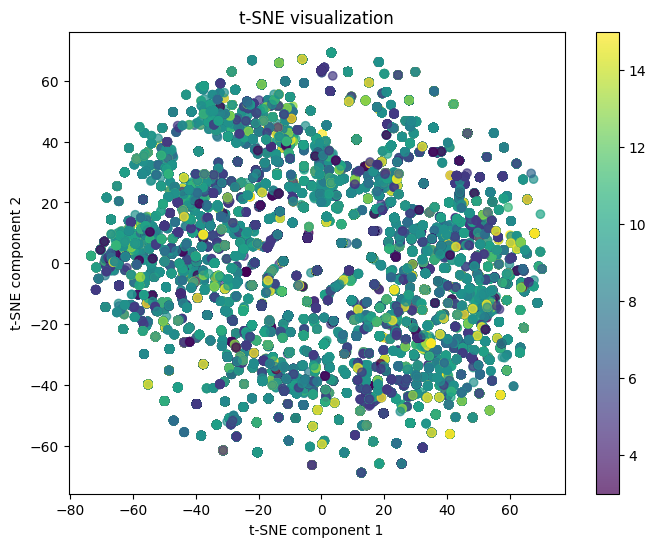

In [ ]:
t_SNE_only=plt.figure(figsize=(8, 6))
t_SNE_only_ax = t_SNE_only.add_subplot(111)
scatter_tsne = t_SNE_only_ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sampled_y, cmap=plt.get_cmap('viridis'), alpha=0.7)
t_SNE_only.colorbar(scatter_tsne)
t_SNE_only_ax.set_title('t-SNE visualization')
t_SNE_only_ax.set_xlabel('t-SNE component 1')
t_SNE_only_ax.set_ylabel('t-SNE component 2')
t_SNE_only=plt.savefig('/content/drive/MyDrive/CAS_2023/t_sne_only.png')
plt.show()

### 7.1.2 t-SNE on PCA output

In [ ]:
# Step 1: Reduce dimensions with PCA

pca = PCA(n_components=50)  # Reduce to 50 components or less
pca_result = pca.fit_transform(sampled_X_train)

In [ ]:
# Just temp
tsne=TSNE(n_components=2, perplexity=50, learning_rate=250, n_iter=1000, random_state=42, n_jobs=-1, verbose=2)

# Step 2: Apply t-SNE on the PCA-reduced data
X_tsne = tsne.fit_transform(pca_result)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.018s...
[t-SNE] Computed neighbors for 100000 samples in 10.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

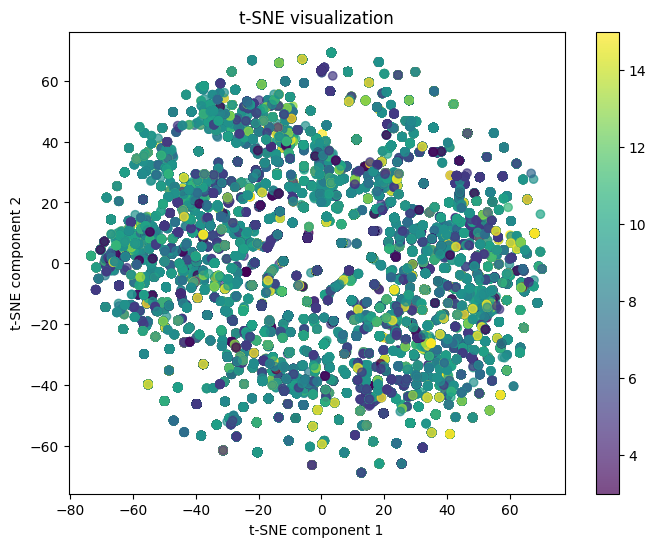

In [ ]:
# Step 3: Plot the results
labels=y_train
pca_tsne=plt.figure(figsize=(8, 6))
pca_tsne_ax=pca_tsne.add_subplot(111)
scatter_pca_tsne = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sampled_y, cmap=plt.get_cmap('viridis'), alpha=0.7)
pca_tsne.colorbar(scatter_pca_tsne)
pca_tsne_ax.set_title('t-SNE visualization')
pca_tsne_ax.set_xlabel('t-SNE component 1')
pca_tsne_ax.set_ylabel('t-SNE component 2')
pca_tsne=plt.savefig('/content/drive/MyDrive/CAS_2023/pca_tsne.png')
plt.show()

### 7.1.3 Comparison

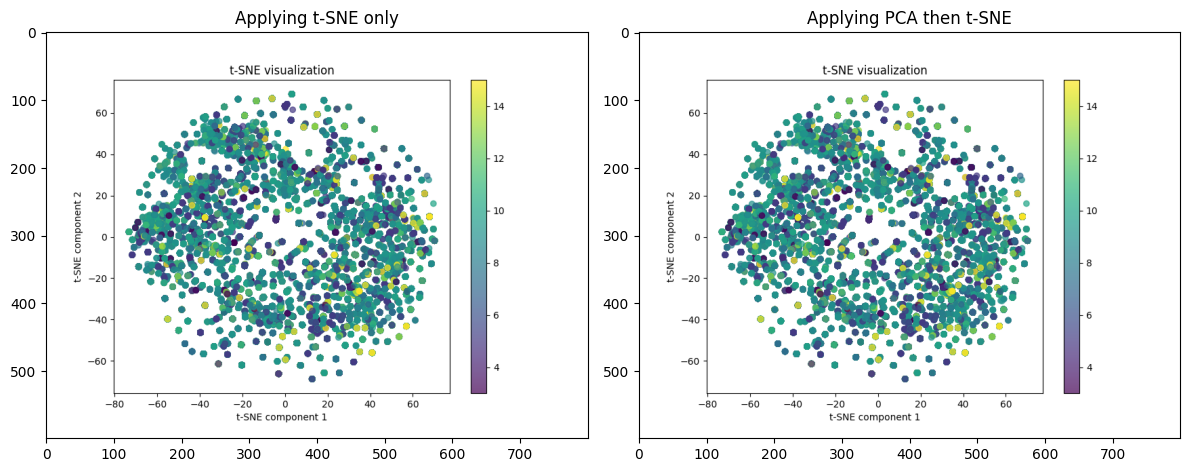

In [ ]:
t_SNE_only=np.asarray(Image.open('/content/drive/MyDrive/CAS_2023/t_sne_only.png'))
pca_tsne=np.asarray(Image.open('/content/drive/MyDrive/CAS_2023/pca_tsne.png'))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axs[0].imshow(t_SNE_only)
axs[0].set_title('Applying t-SNE only')

axs[1].imshow(pca_tsne)
axs[1].set_title('Applying PCA then t-SNE')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CAS_2023/_t_sne_comparison.png')
plt.show()


## 7.2 LLE

In [ ]:
import os

# Limit the number of threads used by OpenBLAS
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
lle=LocallyLinearEmbedding(n_components=2, n_neighbors=10,n_jobs=1, random_state=42)
X_llembedded=lle.fit_transform(sampled_X_train)

In [ ]:
plt.scatter(X_llembedded[:, 0], X_llembedded[:, 1],
            c=sampled_y, cmap='cividis')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.savefig('/content/drive/MyDrive/CAS_2023/lls.png')
plt.title("Unrolled swiss roll using LLE")
plt.show()

## 7.3 K-means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k=5
kmeans=KMeans(n_clusters=k, random_state=42)

In [ ]:
y_pred=kmeans.fit_predict(sampled_X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# 8. Supervised learning

## 8.1 Ensemble learning

In [ ]:
rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                               n_jobs=-1, random_state=42, verbose=1)

In [ ]:
rnd_clf.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.9min finished


RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42, verbose=1)

In [ ]:
y_train_pred_rf=cross_val_predict(rnd_clf, X_train_preprocessed, y_train, cv=2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.9min finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed:   19.4s
[Parallel(n_jobs=96)]: Done 500 out of 500 | elapsed:   32.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    3.1s
[Parallel(n_jobs=96)]: Do

In [ ]:
for score, name in zip(rnd_clf.feature_importances_, df_X_train_preprocessed.columns):
    print(f"{round(score, 2)}: {name}")

0.01: 1H_encoded__stereochemistry_ABSOLUTE
0.01: 1H_encoded__stereochemistry_ACHIRAL
0.0: 1H_encoded__stereochemistry_EPIMERIC
0.0: 1H_encoded__stereochemistry_MIXED
0.0: 1H_encoded__stereochemistry_RACEMIC
0.0: 1H_encoded__optical_activity_( + )
0.0: 1H_encoded__optical_activity_( + / - )
0.01: 1H_encoded__optical_activity_NONE
0.01: 1H_encoded__optical_activity_UNSPECIFIED
0.01: numericals__charge
0.0: numericals__count
0.0: numericals__ez_centers
0.03: log_feat__molecular_weight
0.02: cbrt_feat__stereo_centers
0.0: mlb__005990WHZZ
0.0: mlb__023C2WHX2V
0.0: mlb__029TFK992N
0.0: mlb__02F3473H9O
0.0: mlb__02NG325BQG
0.0: mlb__0324G66D0E
0.0: mlb__0345752X7U
0.0: mlb__03DH2IZ3FY
0.0: mlb__043IPI2M0K
0.0: mlb__059QF0KO0R
0.0: mlb__05JZI7B19X
0.0: mlb__06XEA2VD56
0.0: mlb__076NU497LZ
0.0: mlb__07XHK4SAV6
0.0: mlb__099WOY1SA3
0.0: mlb__0A7M0N7SPE
0.0: mlb__0BZ5A00FQU
0.0: mlb__0E53J927NA
0.05: mlb__0HO1H52958
0.0: mlb__0I3V7S25AW
0.0: mlb__0IRH2BR587
0.0: mlb__0MKJ04EU89
0.0: mlb__0QQJ25X5

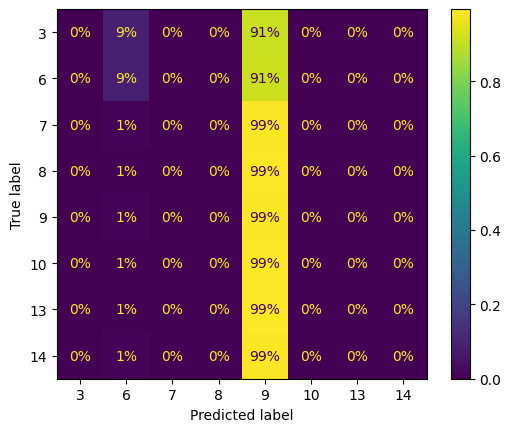

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        normalize='true', values_format=".0%")
plt.show()

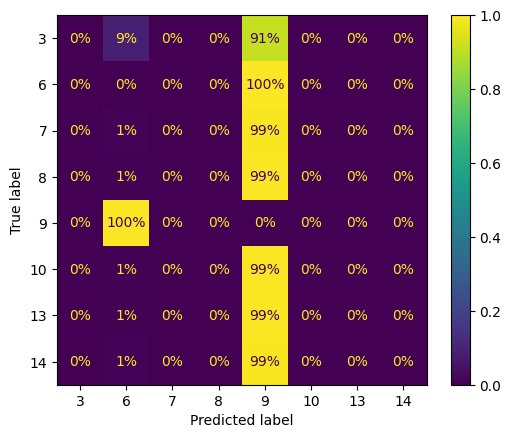

In [ ]:
sample_weight=(y_train_pred_rf != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf,
                                        sample_weight=sample_weight,
                                        normalize='true', values_format=".0%")
plt.show()

## 8.2 Stacking

### 8.2.1 Train and save model indipendently

In [ ]:
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier

In [ ]:
# Define the parameter grid for SVC
svc_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

# Initialize the base SVC model
svc = SVC(probability=True, random_state=42, verbose=1)

# Use GridSearchCV to tune SVC with parallel processing
svc_grid_search = GridSearchCV(estimator=svc, param_grid=svc_param_grid, n_jobs=-1, verbose=2)

# Fit the GridSearchCV on a small part of the dataset to get best params (example)
svc_grid_search.fit(X_train_preprocessed[:1000], y_train_encoded[:1000])

# Get the best SVC model from GridSearchCV
best_svc = svc_grid_search.best_estimator_

# Wrap the best SVC in CalibratedClassifierCV
calibrated_svc = CalibratedClassifierCV(estimator=best_svc, cv='prefit')



Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LibSVM]

In [ ]:
# Base models
base_models = [
    #('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)),
    #('gb', XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=2)),
    ('svm', calibrated_svc)
]

In [ ]:
# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)),
    ('gb', xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1,verbosity=2)),
    ('svm', SVC(probability=True, random_state=42, verbose=1))
]

In [ ]:
for name, model in base_models:
    model.fit(X_train_preprocessed, y_train_encoded)
    joblib.dump(model, f'/content/drive/MyDrive/CAS_2023/{name}_model.pkl')
    print(f"Trained and saved {name} model.")

### 8.2.2 Generate out-of-fold predictions and save them

In [ ]:
# KFold for out-of-fold predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create out-of-fold predictions for training meta-model
def get_oof_predictions(model, X, y, kf):
    oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
    for train_idx, valid_idx in kf.split(X):
        X_train_fold, X_valid_fold = X[train_idx], X[valid_idx]
        y_train_fold, y_valid_fold = y[train_idx], y[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        oof_preds[valid_idx] = model.predict_proba(X_valid_fold)

    return oof_preds

In [ ]:
# Generate and save OOF predictions
oof_preds = np.zeros((X_train_preprocessed.shape[0], len(base_models) * len(np.unique(y_train))))
test_preds = np.zeros((X_test_preprocessed.shape[0], len(base_models) * len(np.unique(y_test))))

for idx, (name, _) in enumerate(base_models):
    model = joblib.load(f'/content/drive/MyDrive/CAS_2023/{name}_model.pkl')
    oof_preds[:, idx*len(np.unique(y_train)):(idx+1)*len(np.unique(y_train))] = get_oof_predictions(model, X_train_preprocessed, y_train, kf)
    test_preds[:, idx*len(np.unique(y_test)):(idx+1)*len(np.unique(y_test))] = model.predict_proba(X_test_preprocessed)

# Save OOF predictions
np.save('/content/drive/MyDrive/CAS_2023/oof_preds.npy', oof_preds)
np.save('/content/drive/MyDrive/CAS_2023/test_preds.npy', test_preds)

### 8.2.3 Train the meta-model using the saved predictions

In [ ]:
# Load OOF predictions
oof_preds = np.load('/content/drive/MyDrive/CAS_2023/oof_preds.npy')
test_preds = np.load('/content/drive/MyDrive/CAS_2023/test_preds.npy')

# Train meta-model
meta_model = LogisticRegression(verbose=1, solver='lbfgs')
meta_model.fit(oof_preds, y_train)

# Save the meta-model
joblib.dump(meta_model, '/content/drive/MyDrive/CAS_2023/meta_model.pkl')

In [ ]:
# Evaluate meta-model
test_meta_preds = meta_model.predict(test_preds)
print("Test Accuracy: ", accuracy_score(y_test, test_meta_preds))

# 9. Neural Networks

In [ ]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## 9.1 Fully connected neural network

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

unique_labels_encoded = np.unique(y_train_encoded)
print("Unique labels after encoding in y_train:", unique_labels_encoded)

Unique labels after encoding in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels_encoded, y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 2.1103758478374206, 1: 0.44785117124983004, 2: 344.754929725194, 3: 1.0164572764865745, 4: 2.6553159742586767, 5: 0.21682983194912653, 6: 0.5438228360709008, 7: 2.7222679123081637, 8: 28.150852175402534, 9: 2.2413153885913553, 10: 464.2504943502825, 11: 1.5922973812229744}


In [ ]:
# Verifications
print("Unique labels in y_train_encoded:", np.unique(y_train_encoded))
print("Unique labels in y_test_encoded:", np.unique(y_test_encoded))
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("X_test_preprocessed shape:", X_test_preprocessed.shape)
print("y_test_encoded shape:", y_test_encoded.shape)

Unique labels in y_train_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique labels in y_test_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11]
X_train_preprocessed shape: (6573787, 706)
y_train_encoded shape: (6573787,)
X_test_preprocessed shape: (1643447, 706)
y_test_encoded shape: (1643447,)


In [ ]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu', input_shape=(706,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               212100    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 12)                1212      
                                                                 
Total params: 243412 (950.83 KB)
Trainable params: 243412 (950.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_preprocessed, y_train_encoded, epochs=30,
                    validation_data=(X_test_preprocessed, y_test_encoded),
                    class_weight=class_weights_dict,
                    batch_size=128)

Epoch 1/30
51358/51358 [==============================] - 229s 4ms/step - loss: 2.4866 - accuracy: 0.0108 - val_loss: nan - val_accuracy: 0.0314
Epoch 2/30
51358/51358 [==============================] - 220s 4ms/step - loss: 2.5550 - accuracy: 0.0143 - val_loss: nan - val_accuracy: 0.0397
Epoch 3/30
51358/51358 [==============================] - 221s 4ms/step - loss: 2.4858 - accuracy: 0.0109 - val_loss: nan - val_accuracy: 4.7461e-04
Epoch 4/30
51358/51358 [==============================] - 221s 4ms/step - loss: 2.4867 - accuracy: 0.0132 - val_loss: nan - val_accuracy: 0.0311
Epoch 5/30
51358/51358 [==============================] - 220s 4ms/step - loss: 2.4908 - accuracy: 0.0129 - val_loss: nan - val_accuracy: 0.0308
Epoch 6/30
51358/51358 [==============================] - 219s 4ms/step - loss: 2.4932 - accuracy: 0.0128 - val_loss: nan - val_accuracy: 3.0485e-04
Epoch 7/30
51358/51358 [==============================] - 221s 4ms/step - loss: 2.4863 - accuracy: 0.0143 - val_loss: nan 

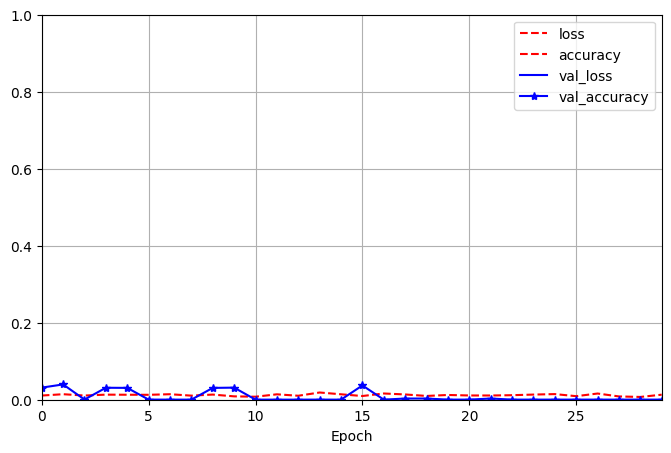

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

## 9.2 Fully connected neural network with regularization and hyperparameter tuning

In [ ]:
model_reg=tf.keras.Sequential([
    tf.keras.layers.Dense(128,input_dim=X_train_preprocessed.shape[1], activation='relu',),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')  # 13 possible classes from 3 to 15
])

In [ ]:
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               90496     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 12)                396       
                                                                 
Total params: 101228 (395.42 KB)
Trainable params: 101228 (395.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
optimizer=Adam(learning_rate=0.001)
model_reg.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
history_reg = model_reg.fit(
    X_train_preprocessed, y_train_encoded,
    epochs=100,
    validation_data=(X_test_preprocessed, y_test_encoded),
    batch_size=256,
    callbacks=[early_stopping]
)


Epoch 1/100
25679/25679 [==============================] - 131s 5ms/step - loss: 1.7372 - accuracy: 0.4206 - val_loss: nan - val_accuracy: 0.4316
Epoch 2/100
25679/25679 [==============================] - 120s 5ms/step - loss: 1.6597 - accuracy: 0.4333 - val_loss: nan - val_accuracy: 0.4225
Epoch 3/100
25679/25679 [==============================] - 121s 5ms/step - loss: 1.6470 - accuracy: 0.4349 - val_loss: nan - val_accuracy: 0.4266
Epoch 4/100
25679/25679 [==============================] - 119s 5ms/step - loss: 1.6413 - accuracy: 0.4357 - val_loss: nan - val_accuracy: 0.4296
Epoch 5/100
25679/25679 [==============================] - 121s 5ms/step - loss: 1.6379 - accuracy: 0.4363 - val_loss: nan - val_accuracy: 0.4253
Epoch 6/100
25679/25679 [==============================] - 120s 5ms/step - loss: 1.6362 - accuracy: 0.4366 - val_loss: nan - val_accuracy: 0.4238
Epoch 7/100
25679/25679 [==============================] - 121s 5ms/step - loss: 1.6348 - accuracy: 0.4367 - val_loss: nan -

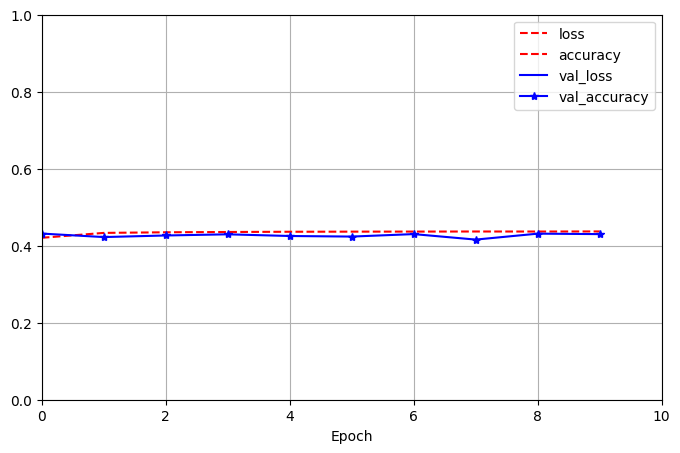

In [ ]:
pd.DataFrame(history_reg.history).plot(
    figsize=(8,5), xlim=[0,10], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*'])
plt.show()

Possible next steps:  
- Use a neural network --> Done
- Try to use some stacking --> Done
- Improve the NN --> tweak params
- Attempt feature combination in the NN --> See chatGPT guide
- Add in supervised learning part some XGBoost